<a href="https://colab.research.google.com/github/Klim2007/wall_mart_sales_kaggle/blob/main/WallMart24_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREDICTION OF SALES BY STORES, CPI & FUEL PRICE 
(USING XGBOOST XGREGRESSOR)

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [260]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost import XGBRegressor
import plotly.express as px
import plotly.graph_objects as go
import datetime
import seaborn as sns

DATA PREPROCESSING

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/walmart-sales-dataset-of-45stores.csv',parse_dates=['Date'])

In [178]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [179]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [180]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106


In [181]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [182]:
df.value_counts()

Store  Date        Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  CPI         Unemployment
1      2010-01-10  1453329.50    0             71.89        2.603       211.671989  7.838           1
30     2012-10-19  437537.29     0             68.52        3.594       223.059808  6.170           1
31     2010-03-12  1338716.37    0             50.43        2.708       211.265543  8.163           1
       2010-03-09  1302047.48    0             82.57        2.577       211.188693  8.099           1
       2010-02-26  1344354.41    0             45.31        2.561       210.975957  8.324           1
                                                                                                   ..
15     2012-10-26  558473.60     0             55.75        4.071       138.728161  7.992           1
       2012-10-19  555652.77     0             52.89        4.153       138.833613  7.992           1
       2012-10-08  590453.63     0             73.99        3.863       138.143774  8.1

Analyzing data and dependancies
1. Store Sales Hollidays vs Working days

In [183]:
store_sales_working = df[df['Holiday_Flag'].isin([0])]
sales_stores = store_sales_working.groupby('Store').Weekly_Sales.mean().reset_index()
fig = px.bar(sales_stores, x = "Store", y ="Weekly_Sales",color="Store",title="Store weekly Sales",height=400)
fig.show()

2.Hollyday_Sales

In [184]:
store_sales_hollidays = df[df['Holiday_Flag'].isin([1])]
a = store_sales_hollidays.groupby(by="Store", dropna=False).mean().reset_index()
fig = px.bar(a, x='Store', y='Weekly_Sales',color='Store',title="Stores Overall Sales")
fig.show()  

employment working days vs hollydays

In [185]:
store_emp_hollidays = df[df['Holiday_Flag'].isin([1])]
store_emp_wrk = df[df['Holiday_Flag'].isin([0])]

store_emp_hollidays['mounth'] = store_emp_hollidays['Date'].dt.month
store_emp_wrk['mounth'] = store_emp_wrk['Date'].dt.month

<ipython-input-185-097336b97de2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-185-097336b97de2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
store_emp_hollidays = store_emp_hollidays.groupby('mounth')['Unemployment'].mean()
store_emp_wrk = store_emp_wrk.groupby('mounth')['Unemployment'].mean()

In [187]:
new_index = []
for i in range (1,13): new_index.append(i)
store_emp_hol = store_emp_hollidays.reindex(new_index)

In [188]:
store_emp_hol

mounth
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7     7.237333
8          NaN
9     8.097489
10    7.968456
11    8.190237
12    8.299607
Name: Unemployment, dtype: float64

In [189]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=months,
    y= store_emp_hol,
    name='unemployment on holidays',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=months,
    y= store_emp_wrk,
    name='unemployment on working days',
    marker_color='lightsalmon'
))

We see that unemployment on holidays is much higher 

CPI index review

In [190]:
CPI_stores = df.groupby('Store').CPI.mean().reset_index()
fig = px.bar(CPI_stores, x='Store', y='CPI',color='Store',title="CPI by Stores")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [191]:
CPI_hollidays = df[df['Holiday_Flag'].isin([1])]
CPI_wrk = df[df['Holiday_Flag'].isin([0])]

CPI_hollidays['mounth'] = CPI_hollidays['Date'].dt.month
CPI_wrk['mounth'] = CPI_wrk['Date'].dt.month

<ipython-input-191-a9381e709855>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-191-a9381e709855>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [192]:
CPI_hollidays.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'mounth'],
      dtype='object')

In [193]:
CPI_on_hollidays = CPI_hollidays.groupby('mounth')['CPI'].mean()
CPI_on_wrk = CPI_wrk.groupby('mounth')['CPI'].mean()

In [194]:
new_index = []
for i in range (1,13): new_index.append(i)
CPI_on_hollidays = CPI_on_hollidays.reindex(new_index)

In [195]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=months,
    y= CPI_on_hollidays,
    name='CPI on holidays',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=months,
    y= CPI_on_wrk,
    name='CPI on working days',
    marker_color='lightsalmon'
))

In [196]:
df['Date']

0      2010-05-02
1      2010-12-02
2      2010-02-19
3      2010-02-26
4      2010-05-03
          ...    
6430   2012-09-28
6431   2012-05-10
6432   2012-12-10
6433   2012-10-19
6434   2012-10-26
Name: Date, Length: 6435, dtype: datetime64[ns]

In [197]:
df['Year'] = df['Date'].dt.strftime('%Y')
df['Mounth'] = df['Date'].dt.strftime('%m')
df['Day'] = df['Date'].dt.strftime('%d')

<Axes: xlabel='Year', ylabel='Fuel_Price'>

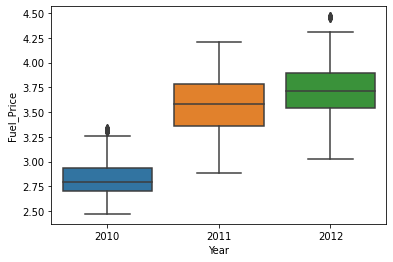

In [198]:
sns.boxplot(x='Year', y='Fuel_Price', data=df)


<Axes: xlabel='Year', ylabel='Unemployment'>

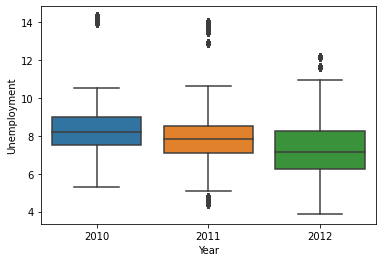

In [199]:
sns.boxplot(x='Year', y='Unemployment', data=df)

<Axes: xlabel='Year', ylabel='CPI'>

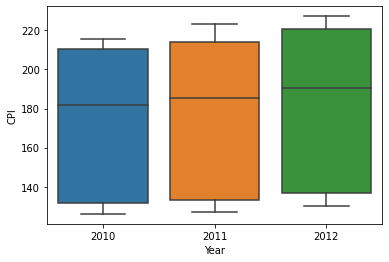

In [200]:
sns.boxplot(x='Year', y='CPI', data=df)

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprec

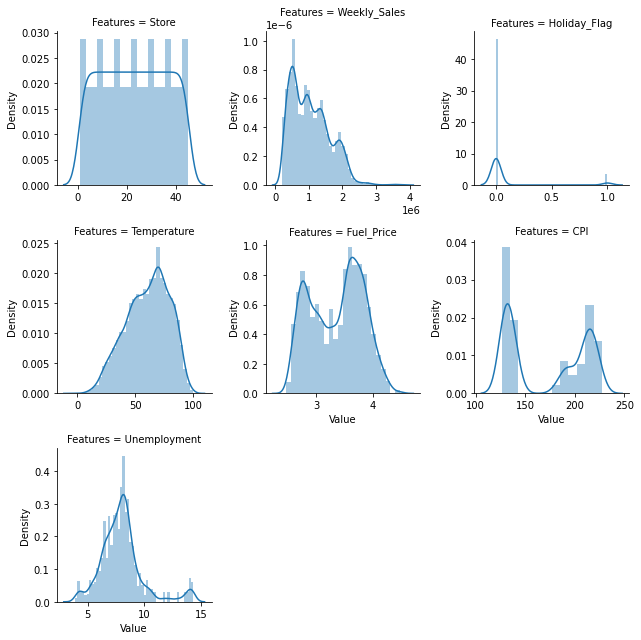

In [201]:
numeric_features = df.drop(df.columns[[1,8,9,10]],axis = 1)

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

In [202]:
numeric_features

,level_0,Features,Value
0,0,Store,1.000000e+00
1,0,Weekly_Sales,1.643691e+06
2,0,Holiday_Flag,0.000000e+00
3,0,Temperature,4.231000e+01
4,0,Fuel_Price,2.572000e+00
...,...,...,...
45040,6434,Holiday_Flag,0.000000e+00
45041,6434,Temperature,5.885000e+01
45042,6434,Fuel_Price,3.882000e+00
45043,6434,CPI,1.923089e+02


In [203]:
df=df.drop(['Date','Day','Year'],axis=1)

In [204]:
# adding 3 more features
mean_month_fuel_price = df.groupby('Mounth')['Fuel_Price'].median().to_dict()
df['mean_month_fuel_price'] = df['Mounth'].map(mean_month_fuel_price)
mean_month_CPI = df.groupby('Mounth')['CPI'].median().to_dict()
df['mean_month_CPI'] = df['Mounth'].map(mean_month_CPI)
mean_month_CPI = df.groupby('Mounth')['CPI'].median().to_dict()
df['mean_month_CPI'] = df['Mounth'].map(mean_month_CPI)

In [205]:
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Mounth,mean_month_fuel_price,mean_month_CPI
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,05,3.595,182.046418
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,12,3.130,182.517732
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,02,3.172,182.077469
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,02,3.172,182.077469
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,05,3.595,182.046418
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,09,3.554,182.669674
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,05,3.595,182.046418
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,12,3.130,182.517732
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,10,3.409,182.855869


In [206]:

df['Store'].astype('float64')
df['Mounth'].astype('float64')

0        5.0
1       12.0
2        2.0
3        2.0
4        5.0
        ... 
6430     9.0
6431     5.0
6432    12.0
6433    10.0
6434    10.0
Name: Mounth, Length: 6435, dtype: float64

In [207]:
X = df.drop('Weekly_Sales', axis=1)
y = df['Weekly_Sales']

In [208]:
X['Store'].astype('object')
X['Mounth'].astype('int64')

0        5
1       12
2        2
3        2
4        5
        ..
6430     9
6431     5
6432    12
6433    10
6434    10
Name: Mounth, Length: 6435, dtype: int64

In [209]:
X['Store'] =  X['Store'].astype('object')
X['Holiday_Flag'] = X['Holiday_Flag'].astype('object')

In [210]:
X.dtypes

Store                     object
Holiday_Flag              object
Temperature              float64
Fuel_Price               float64
CPI                      float64
Unemployment             float64
Mounth                    object
mean_month_fuel_price    float64
mean_month_CPI           float64
dtype: object

In [211]:
numeric =list(X.dtypes[X.dtypes == float].index)
categoric = list(X.dtypes[X.dtypes == object].index)

# Modeling

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

Numeric and Categoric features standartization 

Normalizing  features via logarithm 

In [237]:
for i in X_train[numeric]:
    X_train[i] = np.log(X_train[i]+1)

In [238]:
for i in X_test[numeric]:
    X_test[i] = np.log(X_test[i]+1)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning:

invalid value encountered in log



In [239]:
X_train[categoric].dtypes, X_train[numeric].dtypes 

(Store           object
 Holiday_Flag    object
 Mounth          object
 dtype: object, Temperature              float64
 Fuel_Price               float64
 CPI                      float64
 Unemployment             float64
 mean_month_fuel_price    float64
 mean_month_CPI           float64
 dtype: object)

In [240]:
X_train = pd.get_dummies(X_train, columns=categoric)

/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [241]:
X_test = pd.get_dummies(X_test, columns=categoric)

/usr/local/lib/python3.9/dist-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [242]:
X_train.columns, X_test.columns

(Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'mean_month_fuel_price', 'mean_month_CPI', 'Store_1', 'Store_2',
        'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8',
        'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14',
        'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20',
        'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26',
        'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32',
        'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38',
        'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44',
        'Store_45', 'Holiday_Flag_0', 'Holiday_Flag_1', 'Mounth_01',
        'Mounth_02', 'Mounth_03', 'Mounth_04', 'Mounth_05', 'Mounth_06',
        'Mounth_07', 'Mounth_08', 'Mounth_09', 'Mounth_10', 'Mounth_11',
        'Mounth_12'],
       dtype='object'),
 Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemploy

In [243]:
import xgboost as xgb
XG = xgb.XGBRegressor(objective = 'reg:squarederror' , learning_rate = 0.1,max_depth = 10, n_estimators = 100).fit(X_train, y_train)

In [244]:
XG.score(X_train,y_train) #0.9924816576910022

0.9927868495483698

In [227]:
y_pred_XG = XG.predict(X_test)

In [245]:
print (y_pred_XG)

[1721455.6  1120287.6  1254101.4  ... 2074312.9  1022289.56 1401011.9 ]


In [246]:
print('Training Accuracy :',XG.score(X_train,y_train))
print('Testing Accuracy :',XG.score(X_test,y_test))

Training Accuracy : 0.9927868495483698
Testing Accuracy : 0.9555159239866323


In [282]:
y_test.dtypes

dtype('float64')

In [286]:
pred = pd.DataFrame({'pred':y_pred_XG})
pred['pred']=pred['pred'].astype('float64')
pred.reset_index(drop=True)

,pred
0,1.721456e+06
1,1.120288e+06
2,1.254101e+06
3,4.458967e+05
4,1.024996e+06
...,...
1604,1.997884e+06
1605,5.270345e+05
1606,2.074313e+06
1607,1.022290e+06


In [287]:
compare = pd.concat([y_test,pred],axis=1)


In [288]:
compare.head(20)

,Weekly_Sales,pred
433,1971057.44,1.141710e+06
1770,2003480.59,NaN
1896,1936621.09,NaN
5012,404438.51,NaN
2133,590453.63,NaN
6159,280048.74,NaN
260,1923957.09,3.128573e+05
4624,243948.82,NaN
1184,520846.68,3.131974e+05
3117,939118.24,NaN


In [270]:
fig = px.scatter(compare, x="Weekly_Sales", y="pred",color="Weekly_Sales",trendline="ols") #color='pred'
fig.show()

ValueError: ignored

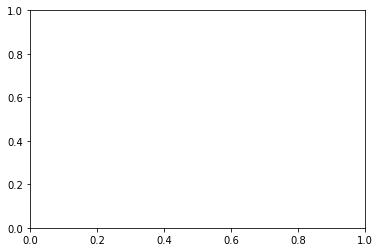

In [264]:
# check mse metric
from sklearn.metrics import mean_squared_error 
mse = mean_squared_error(y_test,pred)

residuals = y_test - pred
plt.scatter(y_test,residuals)
